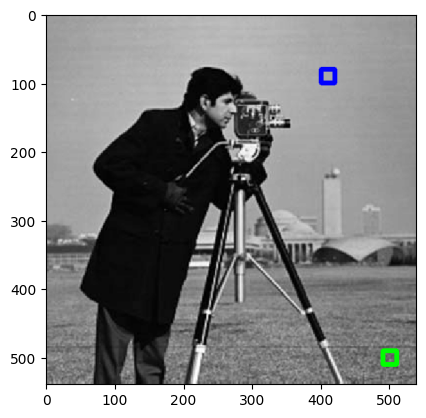

In [21]:
# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('img/photographer.png')

window = cv2.rectangle(img.copy(), (400,80), (420,100), (0, 0, 255), 5)
window = cv2.rectangle(window, (490,490), (510,510), (0, 255, 0), 5)
plt.imshow(window, cmap='gray')
plt.show()

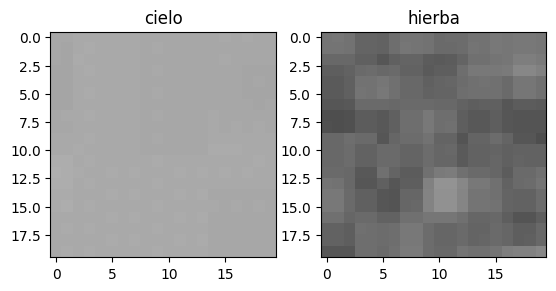

In [22]:
# Seleccionamos una región del cielo y una de la hierba
cielo = img[80:100, 400:420]
hierba = img[490:510, 490:510]

fig, ax = plt.subplots(1,2)
ax[0].imshow(cielo, cmap='gray')
ax[0].set_title('cielo')
ax[1].imshow(hierba, cmap='gray')
ax[1].set_title('hierba')
plt.show()

In [23]:
##############################################################################################################################

In [24]:
# MATRIZ DE COOCURRENCIA (Gray-Level Cooccurence Matrix - GLCM)
from tabulate import tabulate
from skimage.feature import graycomatrix, graycoprops
headers = ['','cielo', 'hierba']
CN, DIS, H, ASM, E, COR = ['contraste'], ['disimilitud'], ['homogeneidad'], ['ASM'], ['Energía'], ['Correlación']

patches = []
patches.append(cielo)
patches.append(hierba)

for i in range(len(patches)):
    image = cv2.cvtColor(patches[i], cv2.COLOR_BGR2GRAY)
    GLCM = graycomatrix(image, distances=[2], angles=[0], levels=np.max(image)+1, symmetric=True, normed=True)
    # print(np.shape(GLCM))
    # plt.imshow(GLCM[:,:,0,0], cmap='gray')
    # plt.show()
    CN.append(graycoprops(GLCM, 'contrast')[0,0])
    DIS.append(graycoprops(GLCM, 'dissimilarity')[0,0])
    H.append(graycoprops(GLCM, 'homogeneity')[0,0])
    ASM.append(graycoprops(GLCM, 'ASM')[0,0])
    E.append(graycoprops(GLCM, 'energy')[0,0])
    COR.append(graycoprops(GLCM, 'correlation')[0,0])

my_data = [tuple(CN), tuple(DIS), tuple(H), tuple(ASM), tuple(E), tuple(COR)]

print(tabulate(my_data, headers=headers))

                 cielo        hierba
------------  --------  ------------
contraste     2.15556   143.1
disimilitud   0.788889    9.25
homogeneidad  0.727447    0.113349
ASM           0.217087    0.00502701
Energía       0.465926    0.0709014
Correlación   0.517086    0.527263


In [25]:
##############################################################################################################################

(1672, 128)


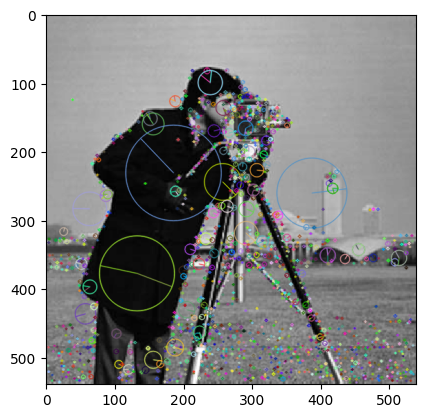

In [26]:
# SIFT algorithm
img = cv2.imread('img/photographer.png', 0)

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp = sift.detect(img, None)

# Extraemos el descriptor para obtener el fingreprint
kp, des = sift.compute(img, kp)
print(np.shape(des))
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
img_int=cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_int)
plt.show()

0.01692507416009903
(1322, 128)


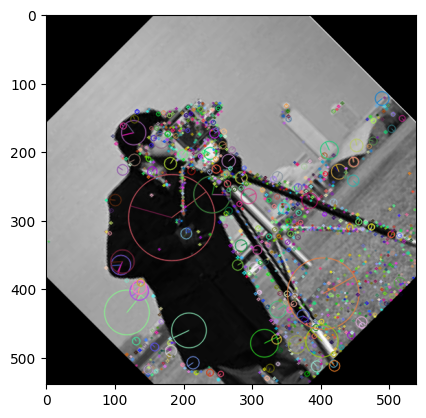

In [27]:
# SIFT algorithm
rows, cols = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),angle=45,scale=1)
img_2 = cv2.warpAffine(img,M,(cols,rows))

# Identificamos los puntos de interés
kp_2 = sift.detect(img_2, None)
k = kp_2[0]
print(k.response)


# Extraemos el descriptor para obtener el fingreprint
kp_2, des_2 = sift.compute(img_2, kp_2)
print(np.shape(des_2))

# Visualizamos los puntos de interés
img_int_2=cv2.drawKeypoints(img_2, kp_2, img_2.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_int_2)
plt.show()

(967,)


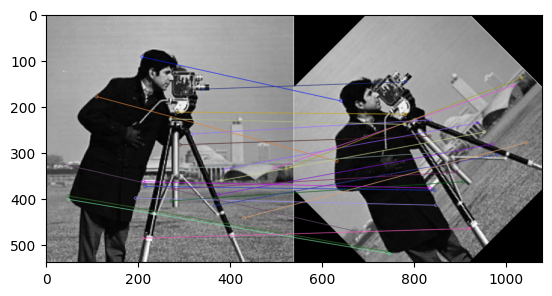

In [28]:
# feature matching
from skimage import io

bf = cv2.BFMatcher.create(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des, des_2)
matches = sorted(matches, key = lambda x:x.distance)

print(np.shape(matches))

img_match = cv2.drawMatches(img, kp, img_2, kp_2, matches[:25], img_2, flags=10)
plt.imshow(img_match)
plt.show()

In [29]:
##############################################################################################################################

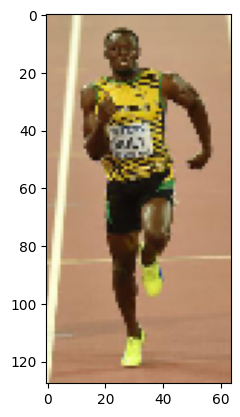

In [30]:
# HISTOGRAM OF ORIENTED GRADIENTS

# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
from skimage import io
img = io.imread('img/pedestrian.jpeg')
img = np.float32(img/255)
crop = img[75:550,475:700]
crop = cv2.resize(crop, (64, 128))

plt.imshow(crop, cmap='gray')
plt.show()

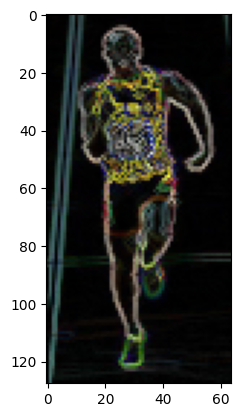

In [31]:
# Calculamos el gradiente con el kernel de Sobel
crop = np.float32(crop)
gx = cv2.Sobel(crop, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(crop, cv2.CV_32F, 0, 1, ksize=1)

# Calculamos la magnitud y la dirección del gradiente
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

# Visualizamos la imagen obtenida en la magnitud del gradiente
mag = mag/np.max(mag)
plt.imshow(mag, cmap='gray')
plt.show()

In [32]:
# Cálculo del desriptor: Histogram of Oriented Gradients
from skimage.feature import hog

# En la última versión de skimage habrá que utilizar una imagen de entrada en escala de grises o
# definir el flag: channel_axis=2 para trabajar en el eje de los canales
H = hog(crop, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", channel_axis=2)
np.shape(H)

(3780,)

In [33]:
##############################################################################################################################

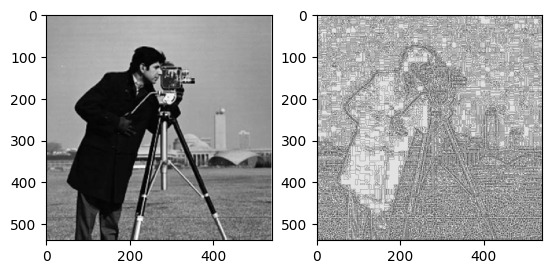

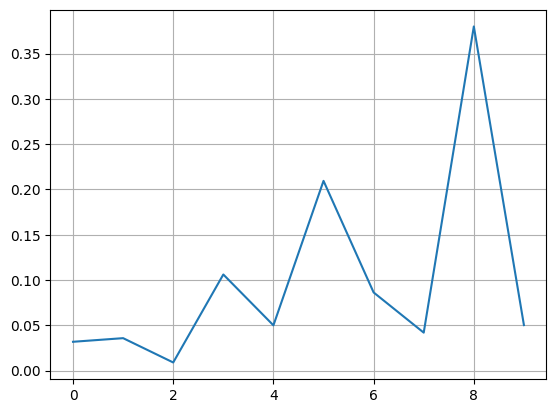

In [34]:
# LOCAL BINARY PATTERNS (LBP)
from skimage.feature import local_binary_pattern
img = cv2.imread('img/photographer.png')

# Definimos los parámetros iniciales
R = 1 # Radio
P = 8*R # Número de píxeles vecinos
epsilon = 1e-7 # Para normalizar el histograma

# Extraemos la imagen LBP
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp_image = local_binary_pattern(img_gray, P, R, method='uniform')
a,b = np.unique(lbp_image, return_counts=True)

# Calculamos el histograma
lbp_image = np.uint8(lbp_image)
hist = cv2.calcHist([lbp_image.ravel()], [0], None, [P+2], [0, P+2])

# Normalizamos el histograma
hist = hist.astype("float")
hist /= (hist.sum() + epsilon)

# Los P+2=10 bins del histograma serán los 10 atributos que nos permitirán caracterizar una imagen

# Visualizamos la imagen LBP
figs, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbp_image, cmap='gray')
plt.show()

# Visualizamos el histograma
plt.plot(hist)
plt.grid(True)
plt.show()